# Importações

In [2]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

from sklearn.preprocessing import StandardScaler as Scaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.metrics import classification_report

from sklearn.neural_network import MLPClassifier

%matplotlib inline

plt.rcParams["figure.figsize"] = (16,10)

# Configurar dataset

### Baixar dados 

**Caso não seja possível baixar os dados do link no dropbox, por favor, baixar no link:**
https://www.kaggle.com/ealaxi/paysim1

In [3]:
!wget -O fraud.csv https://www.dropbox.com/s/47hd95t7n8hhlgz/fraude.csv?dl=0

--2021-09-05 17:52:55--  https://www.dropbox.com/s/47hd95t7n8hhlgz/fraude.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/47hd95t7n8hhlgz/fraude.csv [following]
--2021-09-05 17:52:56--  https://www.dropbox.com/s/raw/47hd95t7n8hhlgz/fraude.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd9bebad0b76cbc306c27239b76.dl.dropboxusercontent.com/cd/0/inline/BVki_5OozjJa5OyTubTtLyMunVmPiXIseReZzaESZHafX8iC8a7GudFngNSfHAsjAtSmcoiTDdxWO412zcChnVmIYJIV2ijZ8ljCRf6X5SNt6WeYgRWuTAAOfTXeafEhqN0diJTdcYAEdbIBJ9P6x_Ve/file# [following]
--2021-09-05 17:52:56--  https://ucd9bebad0b76cbc306c27239b76.dl.dropboxusercontent.com/cd/0/inline/BVki_5OozjJa5OyTubTtLyMunVmPiXIseReZzaESZHafX8iC8a7GudFngNSfHAsjAtSmcoiTDdxWO412zcChnVmIYJI

In [4]:
dataset_path = "fraud.csv"

### Ler CSV

In [5]:
df = pd.read_csv(dataset_path)

# 3 - Preparação dos dados

## 3.1 - Normalização logarítimica

In [6]:
df['amount'].describe()

count    6.362620e+06
mean     1.798619e+05
std      6.038582e+05
min      0.000000e+00
25%      1.338957e+04
50%      7.487194e+04
75%      2.087215e+05
max      9.244552e+07
Name: amount, dtype: float64

In [7]:
df['oldbalanceOrg'].describe()

count    6.362620e+06
mean     8.338831e+05
std      2.888243e+06
min      0.000000e+00
25%      0.000000e+00
50%      1.420800e+04
75%      1.073152e+05
max      5.958504e+07
Name: oldbalanceOrg, dtype: float64

In [8]:
df['newbalanceOrig'].describe()

count    6.362620e+06
mean     8.551137e+05
std      2.924049e+06
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.442584e+05
max      4.958504e+07
Name: newbalanceOrig, dtype: float64

In [9]:
df['oldbalanceDest'].describe()

count    6.362620e+06
mean     1.100702e+06
std      3.399180e+06
min      0.000000e+00
25%      0.000000e+00
50%      1.327057e+05
75%      9.430367e+05
max      3.560159e+08
Name: oldbalanceDest, dtype: float64

In [10]:
df['newbalanceDest'].describe()

count    6.362620e+06
mean     1.224996e+06
std      3.674129e+06
min      0.000000e+00
25%      0.000000e+00
50%      2.146614e+05
75%      1.111909e+06
max      3.561793e+08
Name: newbalanceDest, dtype: float64

Todos tem como valor mínimo 0. log 0 é impossível, logo deve-se mudar os valores para retirar o 0 antes de mudar a escala para logarítmica.

In [11]:
log_list = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

for i in log_list:
    df[i] = (0.1+df[i])#Como existem valores iguais a 0, é preciso tirá-los para fazer o log
    df[i] = np.log(df[i])

## 3.2 - Separação dos dados
É preciso separar os dados em treino, teste e validação antes de normalizar os dados, caso contrário ocorrerá vazamento de dados.
60% dos dados serão usados no grupo de treinamento, 25% no grupo de validação e 15% no grupo de teste.

### 3.2.1 - Separa em treino, teste e validacao

In [12]:
tamanho_df = df.shape[0]
colunas_y = ["isFraud"]
colunas_nao_x = ["isFraud", "isFlaggedFraud"]
colunas_x = [coluna for coluna in df.columns if coluna not in colunas_nao_x]

# Treino 
fim_treino = round(tamanho_df * 0.6)

treino = df.loc[0:fim_treino,:]
fraudes_treino = treino[treino['isFraud'] == 1]
legitimo_treino = treino[treino['isFraud'] == 0]
legitimo_treino = legitimo_treino.sample(n=fraudes_treino.shape[0], random_state=1)
treino_balanceado = pd.concat([legitimo_treino, fraudes_treino], axis= 0)
x_treino_balanceado = treino_balanceado.loc[:, colunas_x]
y_treino_balanceado = treino_balanceado.loc[:, colunas_y]

x_treino = df.loc[0:fim_treino,colunas_x]
y_treino = df.loc[0:fim_treino, colunas_y]


# Validacao
fim_validacao = round(tamanho_df * (0.6 + 0.25))

validacao = df.loc[fim_treino:fim_validacao,:]
fraudes_validacao = validacao[validacao['isFraud'] == 1]
legitimo_validacao = validacao[validacao['isFraud'] == 0]
legitimo_validacao = legitimo_validacao.sample(n=fraudes_validacao.shape[0], random_state=1)
validacao_balanceado = pd.concat([legitimo_validacao, fraudes_validacao], axis= 0)
x_validacao_balanceado = validacao_balanceado.loc[:, colunas_x]
y_validacao_balanceado = validacao_balanceado.loc[:, colunas_y]

x_validacao = df.loc[fim_treino:fim_validacao, colunas_x]
y_validacao =  df.loc[fim_treino:fim_validacao, colunas_y]

# Teste

teste = df.loc[fim_validacao:tamanho_df,:]
fraudes_teste = teste[teste['isFraud'] == 1]
legitimo_teste = teste[teste['isFraud'] == 0]
legitimo_teste = legitimo_teste.sample(n=fraudes_teste.shape[0], random_state=1)
teste_balanceado = pd.concat([legitimo_teste, fraudes_teste], axis= 0)
x_teste_balanceado = teste_balanceado.loc[:, colunas_x]
y_teste_balanceado = teste_balanceado.loc[:, colunas_y]

x_teste =  df.loc[fim_validacao:tamanho_df , colunas_x]
y_teste = df.loc[fim_validacao:tamanho_df, colunas_y]

In [13]:
print(x_treino.shape)
print(x_validacao.shape)
print(x_teste.shape)

print(x_treino_balanceado.shape)
print(y_treino_balanceado.shape)
print(x_validacao_balanceado.shape)
print(y_validacao_balanceado.shape)
print(x_teste_balanceado.shape)
print(y_teste_balanceado.shape)

(3817573, 9)
(1590656, 9)
(954393, 9)
(6378, 9)
(6378, 1)
(2032, 9)
(2032, 1)
(8016, 9)
(8016, 1)


## 3.3 - Padronização dos dados
Apenas variáveis contínuas e discretas devem ser padronizadas.

In [14]:
colunas_scaler = ["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]
scaler = Scaler()

x_treino_balanceado[colunas_scaler] = scaler.fit_transform(x_treino_balanceado[colunas_scaler])

x_validacao_balanceado[colunas_scaler] = scaler.transform(x_validacao_balanceado[colunas_scaler])

x_teste_balanceado[colunas_scaler] = scaler.transform(x_teste_balanceado[colunas_scaler])

In [15]:
scaler = Scaler()

x_treino[colunas_scaler] = scaler.fit_transform(x_treino[colunas_scaler])

x_validacao[colunas_scaler] = scaler.transform(x_validacao[colunas_scaler])

x_teste[colunas_scaler] = scaler.transform(x_teste[colunas_scaler])

In [16]:
x_treino.head(2)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest
0,1,PAYMENT,-0.878175,C1231006815,0.803964,1.054779,M1979787155,-1.156928,-1.256277
1,1,PAYMENT,-1.789201,C1666544295,0.492848,0.771232,M2044282225,-1.156928,-1.256277


In [17]:
x_validacao_balanceado.head(2)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest
3998125,298,TRANSFER,0.746727,C275945467,-2.060802,-0.531852,C1644909153,1.385417,1.151396
4658759,330,PAYMENT,-1.519311,C62030761,0.422256,1.770014,M182672016,-0.920817,-1.118828


## 3.4 - Tratamento de variáveis categóricas

### 3.4.1 - Corrigindo variáveis nameOrig e nameDest

In [18]:
x_treino.loc[x_treino['nameDest'].astype(str).str[0] == 'C', 'nameDest'] = 'C'
x_treino.loc[x_treino['nameDest'].astype(str).str[0] == 'M', 'nameDest'] = 'M'
x_treino_balanceado.loc[x_treino_balanceado['nameDest'].astype(str).str[0] == 'C', 'nameDest'] = 'C'
x_treino_balanceado.loc[x_treino_balanceado['nameDest'].astype(str).str[0] == 'M', 'nameDest'] = 'M'

x_validacao.loc[x_validacao['nameDest'].astype(str).str[0] == 'C', 'nameDest'] = 'C'
x_validacao.loc[x_validacao['nameDest'].astype(str).str[0] == 'M', 'nameDest'] = 'M'
x_validacao_balanceado.loc[x_validacao_balanceado['nameDest'].astype(str).str[0] == 'C', 'nameDest'] = 'C'
x_validacao_balanceado.loc[x_validacao_balanceado['nameDest'].astype(str).str[0] == 'M', 'nameDest'] = 'M'

x_teste.loc[x_teste['nameDest'].astype(str).str[0] == 'C', 'nameDest'] = 'C'
x_teste.loc[x_teste['nameDest'].astype(str).str[0] == 'M', 'nameDest'] = 'M'
x_teste_balanceado.loc[x_teste_balanceado['nameDest'].astype(str).str[0] == 'C', 'nameDest'] = 'C'
x_teste_balanceado.loc[x_teste_balanceado['nameDest'].astype(str).str[0] == 'M', 'nameDest'] = 'M'

In [19]:
x_treino.loc[x_treino['nameOrig'].astype(str).str[0] == 'C', 'nameOrig'] = 'C'
x_treino_balanceado.loc[x_treino_balanceado['nameOrig'].astype(str).str[0] == 'C', 'nameOrig'] = 'C'

x_validacao.loc[x_validacao['nameOrig'].astype(str).str[0] == 'C', 'nameOrig'] = 'C'
x_validacao_balanceado.loc[x_validacao_balanceado['nameOrig'].astype(str).str[0] == 'C', 'nameOrig'] = 'C'

x_teste.loc[x_teste['nameOrig'].astype(str).str[0] == 'C', 'nameOrig'] = 'C'
x_teste_balanceado.loc[x_teste_balanceado['nameOrig'].astype(str).str[0] == 'C', 'nameOrig'] = 'C'

In [20]:
x_treino.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest
0,1,PAYMENT,-0.878175,C,0.803964,1.054779,M,-1.156928,-1.256277
1,1,PAYMENT,-1.789201,C,0.492848,0.771232,M,-1.156928,-1.256277
2,1,TRANSFER,-3.066135,C,-0.219784,-0.862883,C,-1.156928,-1.256277
3,1,CASH_OUT,-3.066135,C,-0.219784,-0.862883,C,0.406175,-1.256277
4,1,PAYMENT,-0.784832,C,0.593151,0.829336,M,-1.156928,-1.256277
5,1,PAYMENT,-1.004149,C,0.631945,0.887343,M,-1.156928,-1.256277
6,1,PAYMENT,-1.056287,C,0.815024,1.067389,M,-1.156928,-1.256277
7,1,PAYMENT,-1.001081,C,0.809106,1.061259,M,-1.156928,-1.256277
8,1,PAYMENT,-1.367800,C,0.182698,-0.862883,M,-1.156928,-1.256277
9,1,DEBIT,-1.213123,C,0.593748,0.855737,C,0.493113,0.405974


In [21]:
x_treino['type'].value_counts()

CASH_OUT    1356166
PAYMENT     1286109
CASH_IN      836483
TRANSFER     315348
DEBIT         23467
Name: type, dtype: int64

### 3.4.2 - OneHotEncoder

In [22]:
onehotencoder_ = ColumnTransformer(transformers=[('OneHot', OneHotEncoder(), [1,3,6])], remainder='passthrough')

x_treino = onehotencoder_.fit_transform(x_treino)
x_treino_balanceado = onehotencoder_.fit_transform(x_treino_balanceado)
x_validacao = onehotencoder_.fit_transform(x_validacao)
x_validacao_balanceado = onehotencoder_.fit_transform(x_validacao_balanceado)
x_teste = onehotencoder_.fit_transform(x_teste)
x_teste_balanceado = onehotencoder_.fit_transform(x_teste_balanceado)

In [23]:
print(x_treino.shape)
print(x_validacao.shape)
print(x_teste.shape)

print(x_treino_balanceado.shape)
print(x_validacao_balanceado.shape)
print(x_teste_balanceado.shape)

(3817573, 14)
(1590656, 14)
(954393, 14)
(6378, 14)
(2032, 14)
(8016, 14)


## 3.5 - Ajustes finais

In [24]:
y_treino = y_treino.to_numpy()
y_treino_balanceado = y_treino_balanceado.to_numpy()

y_validacao = y_validacao.to_numpy()
y_validacao_balanceado = y_validacao_balanceado.to_numpy()

y_teste = y_teste.to_numpy()
y_teste_balanceado = y_teste_balanceado.to_numpy()

In [25]:
y_treino = y_treino.ravel()
y_treino_balanceado = y_treino_balanceado.ravel()

y_validacao = y_validacao.ravel()
y_validacao_balanceado = y_validacao_balanceado.ravel()

y_teste = y_teste.ravel()
y_teste_balanceado = y_teste_balanceado.ravel()

In [26]:
unique, counts = np.unique(x_treino[:,1], return_counts=True)
print(unique, counts)

[0. 1.] [2461407 1356166]


# 4 - Classificadores

## 4.1 - Regressão Logística

In [27]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

### 4.1.1 - Dados Balanceados

In [28]:
lr = LogisticRegression(max_iter=1500)

In [29]:
lr.fit(x_treino_balanceado, y_treino_balanceado)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [30]:
lr.score(x_teste, y_teste)

0.8405457709769456

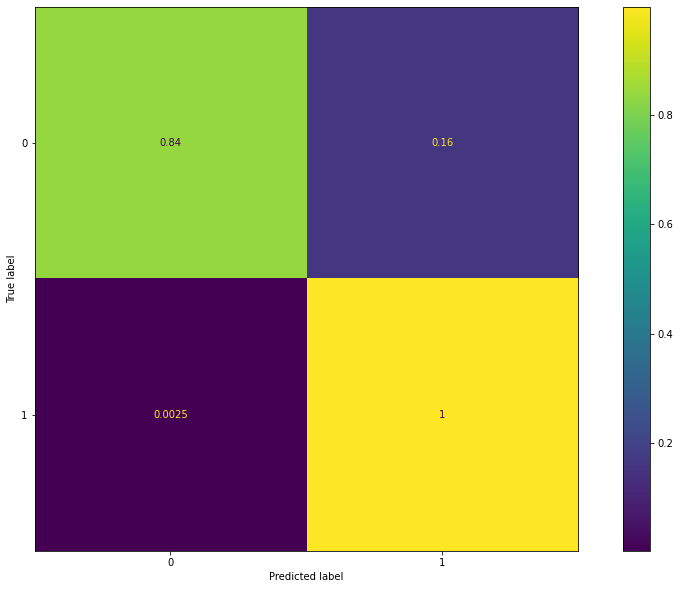

In [31]:
plot_confusion_matrix(lr, x_teste, y_teste, normalize='true')
plt.show()

In [36]:
y_predict = lr.predict(x_teste)
lr_f1_score = f1_score(y_teste, y_predict, average='weighted')
print(lr_f1_score)

0.9093452274769689


### Respondendo perguntas

In [37]:
fraude_detectada = []
fraude_real = []
legitimo_detectado = []
legitimo_real = []
for i in range(len(y_predict)):
    if y_predict[i]==y_teste[i] and y_teste[i]==1:
        fraude_real.append(fim_validacao+i)
    if y_predict[i]==1 and y_teste[i]==0:
        fraude_detectada.append(fim_validacao+i)
    if y_predict[i]==0 and y_teste[i]==1:
        legitimo_detectado.append(fim_validacao+i)
    if y_predict[i]==y_teste[i] and y_teste[i]==0:
        legitimo_real.append(fim_validacao+i)

In [38]:
df = pd.read_csv(dataset_path)

##### Lucro 100% de acertos

In [39]:
df_100 = df.loc[fim_validacao:tamanho_df,:]
df_100_fraude = df_100[df_100['isFraud']==1]
df_100_legitimo = df_100[df_100['isFraud']==0]

In [40]:
lucro_100_porcento = df_100_fraude['amount'].sum()/4 + df_100_legitimo['amount'].sum()/50

In [41]:
lucro_100_porcento

4662745125.904598

##### Prejuízo falha do modelo

In [42]:
df_falha = df.loc[fim_validacao:tamanho_df,:]
df_falha_fraude = df_falha[df_falha['isFraud']==1]
df_falha_legitimo = df_falha[df_falha['isFraud']==0]

In [43]:
prejuizo_falha = -(df_falha_fraude['amount'].sum() + df_falha_legitimo['amount'].sum()/20)

In [44]:
prejuizo_falha

-14028146116.781496

##### Lucro real do modelo

In [45]:
df_fraude_real = df.iloc[fraude_real]
df_fraude_detectada = df.iloc[fraude_detectada]
df_legitimo_detectado = df.iloc[legitimo_detectado]
df_legitimo_real = df.iloc[legitimo_real]

In [46]:
soma_fraude_real = df_fraude_real['amount'].sum()
soma_fraude_detectada = df_fraude_detectada['amount'].sum()
soma_legitimo_detectado = df_legitimo_detectado['amount'].sum()
soma_legitimo_real = df_legitimo_real['amount'].sum()

In [47]:
lucro_modelo = (soma_fraude_real/4) + (soma_legitimo_real/50) - (soma_fraude_detectada/20) - soma_legitimo_detectado

In [48]:
lucro_modelo

2170636804.4699006

### Análise dos coeficientes

In [49]:
df.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


In [50]:
transferCoef = lr.coef_[0][4]
transferCoef

2.0669485821785183

In [51]:
x_treino[3]
# Cash out index 1

array([ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  1.        ,  0.        ,  1.        , -3.06613468,
       -0.2197836 , -0.86288335,  0.40617471, -1.25627716])

In [52]:
cashoutCoef = lr.coef_[0][1]
cashoutCoef

2.9857396349300087

In [53]:
x_treino[0]
# Payment index 3

array([ 0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        1.        ,  0.        ,  1.        ,  1.        , -0.87817485,
        0.80396415,  1.05477851, -1.15692785, -1.25627716])

In [54]:
paymentCoef = lr.coef_[0][3]
paymentCoef

-1.9932395796710725

In [56]:
x_treino[10]
# Debit index 2

array([ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        1.        ,  1.        ,  0.        ,  1.        , -0.88912002,
        0.25953897, -0.86288335,  0.32084764,  0.58174484])

In [57]:
debitCoef = lr.coef_[0][2]
debitCoef

-0.9873454568480794

In [58]:
x_treino[19996]
# Cash in index 0

array([1.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 1.        , 0.        , 8.        , 0.49848819,
       0.38642185, 1.02866966, 0.60332913, 0.520324  ])

In [59]:
cashinCoef = lr.coef_[0][0]
cashinCoef

-2.1361385490805977

Vendo os coeficientes da nossa regressão logística foi possível reafirmar nossos testes de hipótese. Os coeficientes de tipos de transação que não são os de transferência ou de saque são negativos, contribuindo para que a saída seja 0 (não fraude). Já os coeficientes de tipos de transação de transferência ou de saque são positivos, contribuindo para que a saída seja 1 (fraude). Vimos que a probabilidade de uma transferência ser fraude é maior que a de saque, contudo o coeficiente do saque é maior que o da transferência, isso pode ser explicado pelo fato das outras váriaveis serem dependentes da váriavel de tipo de transação.

### 4.1.2 - Dados não balanceados

In [ ]:
lr = LogisticRegression()

In [ ]:
lr.fit(x_treino,y_treino)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
lr.score(x_teste, y_teste)

0.9978478467465709

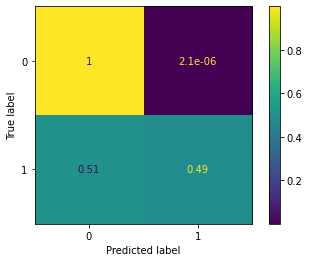

In [ ]:
plot_confusion_matrix(lr, x_teste, y_teste, normalize='true')
plt.show()

## 4.2 - Rede Neural MLP

### Treinamento

In [ ]:
plt.rcParams["figure.figsize"] = (6,4)
dict_modelos = dict()
tamanhos_rede = [1,2,5,10,15,20,25,30]
#tamanhos_rede = [10]

for numero_neuronio in tamanhos_rede:
    
    modelo_MLP = MLPClassifier( hidden_layer_sizes = numero_neuronio, activation = 'relu' , 
                               solver = 'adam' , 
                               alpha = 0.0001 , 
                               batch_size = 'auto' , 
                               learning_rate = 'constant' , 
                               learning_rate_init = 0.01 , 
                               power_t = 0.5 , 
                               max_iter = 500 , 
                               shuffle = True , 
                               random_state = None , 
                               tol= 0.0001 , 
                               verbose = False , 
                               warm_start = False , 
                               momentum = 0.9 , 
                               nesterovs_momentum = True , 
                               early_stopping = False , 
                               validation_fraction = 0.1 , 
                               beta_1 = 0.9, 
                               beta_2 = 0.999 , 
                               epsilon = 1e-08 , 
                               n_iter_no_change = 10 , 
                               max_fun = 15000)
    
    modelo_MLP.fit(np.array(x_treino_balanceado), np.array(y_treino_balanceado))
    
    
    dict_modelos[f"numero_neuronio_{numero_neuronio}"] = modelo_MLP

In [ ]:
def mostra_resultados_modelo(dict_modelos, numero_neuronio):   
    """ Retorna a matriz de confusao dos dados de treino e dos dados de teste"""
    
    print(f"--- Modelo com {numero_neuronio} Neuronios ---")
    modelo_MLP = dict_modelos[f"numero_neuronio_{numero_neuronio}"] 

    plot_confusion_matrix(modelo_MLP, np.array(x_validacao), 
                          np.array(y_validacao), 
                          normalize='true')  
    
    plot_confusion_matrix(modelo_MLP, np.array(x_teste), 
                          np.array(y_teste), 
                          normalize='true')

--- Modelo com 1 Neuronios ---


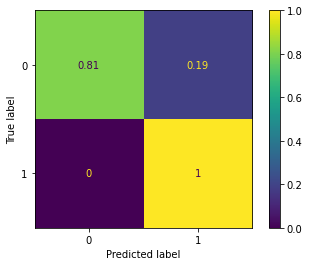

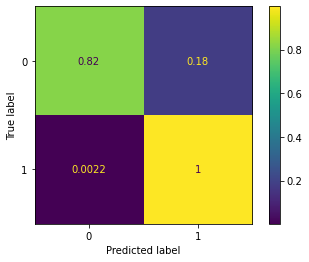

In [ ]:
mostra_resultados_modelo(dict_modelos, 1)

--- Modelo com 2 Neuronios ---


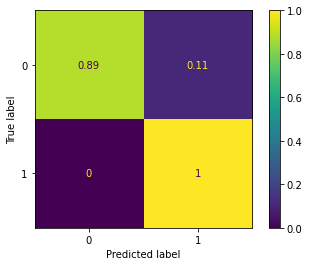

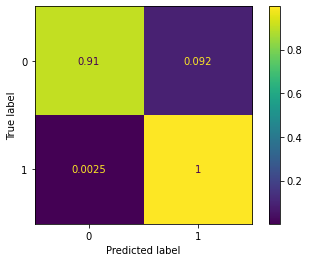

In [ ]:
mostra_resultados_modelo(dict_modelos, 2)

--- Modelo com 5 Neuronios ---


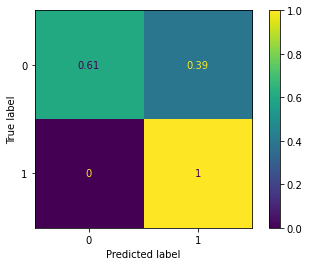

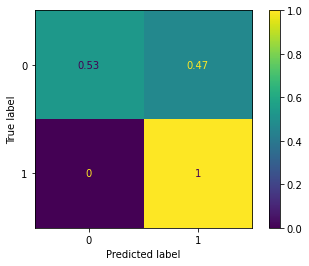

In [ ]:
mostra_resultados_modelo(dict_modelos, 5)

--- Modelo com 10 Neuronios ---


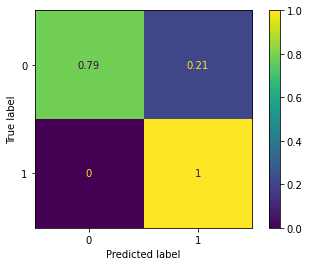

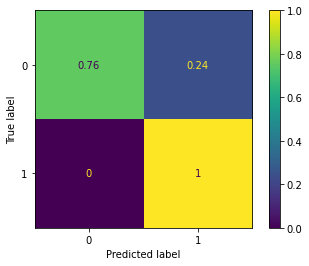

In [ ]:
mostra_resultados_modelo(dict_modelos, 10)

--- Modelo com 15 Neuronios ---


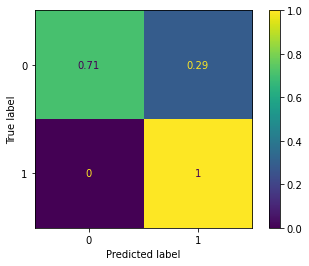

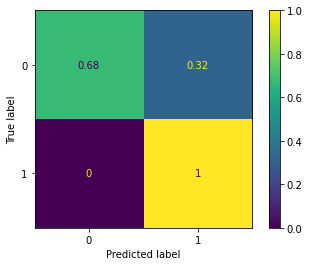

In [ ]:
mostra_resultados_modelo(dict_modelos, 15)

--- Modelo com 20 Neuronios ---


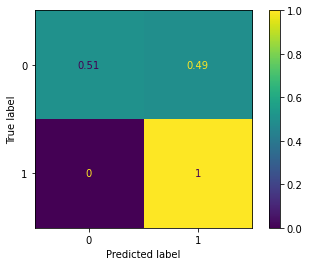

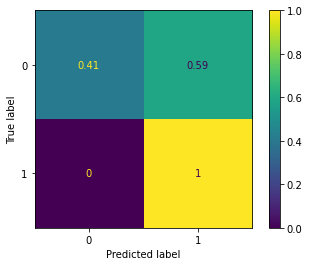

In [ ]:
mostra_resultados_modelo(dict_modelos, 20)

--- Modelo com 25 Neuronios ---


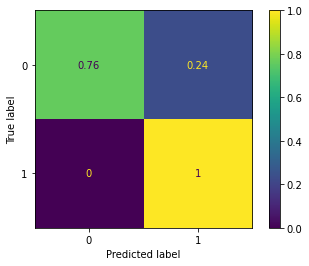

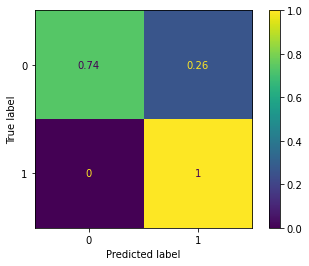

In [ ]:
mostra_resultados_modelo(dict_modelos, 25)

--- Modelo com 30 Neuronios ---


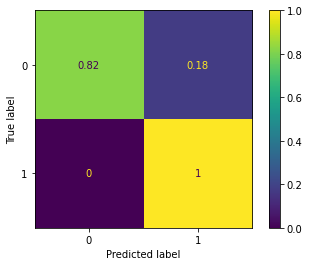

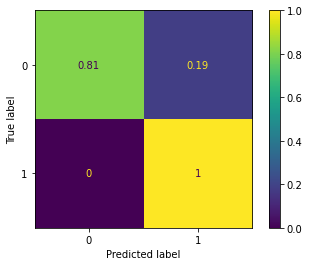

In [ ]:
mostra_resultados_modelo(dict_modelos, 30)

In [ ]:
dict_modelos[f"numero_neuronio_2"].score(x_teste, y_teste)

0.9084685239728288

### Melhor modelo encontrado
Salvamos na pasta notebooks no github um arquivo chamado modelo_MLP que armazena os dados do melhor modelo que conseguimos treinar. Para carregá-lo, caso já não esteja na mesma pasta que esse notebook, adicione ele à mesma pasta.

In [ ]:
#Salva o modelo
#pickle.dump(dict_modelos[f"numero_neuronio_2"] , open("modelo_MLP_2", 'wb'))

In [ ]:
# Lê o modelo
modelo_MLP = pickle.load(open("modelo_MLP_2", 'rb'))
dict_modelos = dict()
dict_modelos["numero_neuronio_2"] = modelo_MLP

In [ ]:
def mostra_resultados_modelo(dict_modelos, numero_neuronio):   
    """ Retorna a matriz de confusao dos dados de treino e dos dados de teste"""
    
    print(f"--- Modelo com {numero_neuronio} Neuronios ---")
    modelo_MLP = dict_modelos[f"numero_neuronio_{numero_neuronio}"] 
    
    plot_confusion_matrix(modelo_MLP, np.array(x_validacao), 
                          np.array(y_validacao), 
                          normalize='true')  
    
    plot_confusion_matrix(modelo_MLP, np.array(x_teste), 
                          np.array(y_teste), 
                          normalize='true')

--- Modelo com 30 Neuronios ---


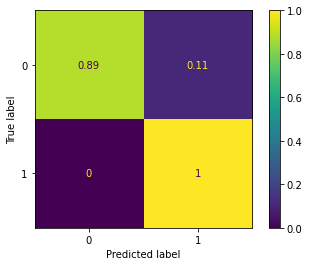

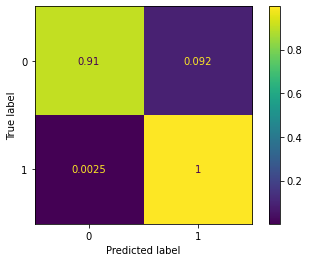

In [ ]:
mostra_resultados_modelo(dict_modelos, 2)

### Bootstrap no Modelo MLP

In [ ]:
MLP_results_2 = []
MLP_results_30 = []
iteracoes = 1000
list_camadas = [2,30]
for i in range(iteracoes):
    for n_camadas in list_camadas:
        modelo_MLP = MLPClassifier( hidden_layer_sizes = n_camadas, activation = 'relu' , 
                                  solver = 'adam' , 
                                  alpha = 0.0001 , 
                                  batch_size = 'auto' , 
                                  learning_rate = 'constant' , 
                                  learning_rate_init = 0.01 , 
                                  power_t = 0.5 , 
                                  max_iter = 500 , 
                                  shuffle = True , 
                                  random_state = None , 
                                  tol= 0.0001 , 
                                  verbose = False , 
                                  warm_start = False , 
                                  momentum = 0.9 , 
                                  nesterovs_momentum = True , 
                                  early_stopping = False , 
                                  validation_fraction = 0.1 , 
                                  beta_1 = 0.9, 
                                  beta_2 = 0.999 , 
                                  epsilon = 1e-08 , 
                                  n_iter_no_change = 10 , 
                                  max_fun = 15000)
    
        modelo_MLP.fit(np.array(x_treino_balanceado), np.array(y_treino_balanceado))

        y_pred = modelo_MLP.predict(x_teste)
        if n_camadas==2:
            MLP_results_2.append(f1_score(y_teste, y_pred, average='weighted'))
        elif n_camadas==30:
            MLP_results_30.append(f1_score(y_teste, y_pred, average='weighted'))

In [ ]:
print(np.mean(MLP_results_2), np.mean(MLP_results_30))

0.8808606557078458 0.871762924874739


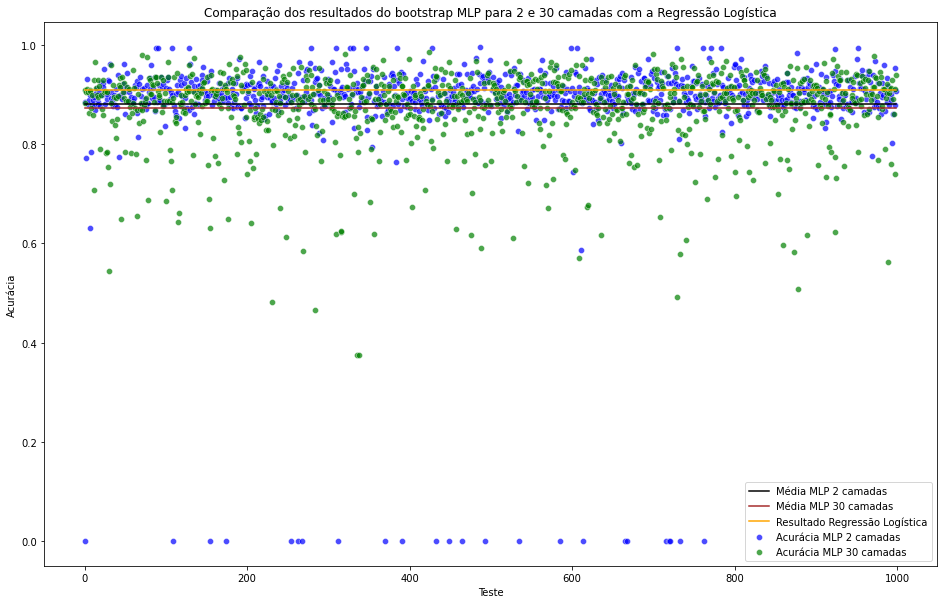

In [ ]:
sns.scatterplot(x=[i for i in range(1000)] , y=MLP_results_2, label='Acurácia MLP 2 camadas', color='Blue', alpha=0.7)
sns.scatterplot(x=[i for i in range(1000)] , y=MLP_results_30, label='Acurácia MLP 30 camadas', color='Green', alpha=0.7)

# Média
sns.lineplot(x=[i for i in range(1000)], y=[np.mean(MLP_results_2) for i in range(1000)], color='Black', 
             label='Média MLP 2 camadas')
sns.lineplot(x=[i for i in range(1000)], y=[np.mean(MLP_results_30) for i in range(1000)], color='Brown', 
             label='Média MLP 30 camadas')
sns.lineplot(x=[i for i in range(1000)], y=[lr_f1_score for i in range(1000)], color='Orange', 
             label='Resultado Regressão Logística')

plt.title('Comparação dos resultados do bootstrap MLP para 2 e 30 camadas com a Regressão Logística')
plt.xlabel('Teste')
plt.ylabel('Acurácia')
plt.show()